In [305]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import db_builder.db_handler as dbh
import logging
from getpass import getpass
from datetime import datetime

In [306]:
logging.getLogger('sqlalchemy').setLevel(logging.WARNING)

In [307]:
db_params = {
    'user': 'postgres',
    'password': getpass('Please enter DB pw'),  # enter your DB password
    'host': 'localhost',  # 'localhost' or IP address
    'port': '5432',  # '5432'
    'database': 'ttdatabase', #tensionTerminator
}

In [308]:
toolcheck = dbh.DB_Conn(db_params)
toolcheck.connect()
engine  = toolcheck.get_engine()

Connected to PostgreSQL, DB: ttdatabase


In [309]:
def table_to_df(tabel_name: str):
    return pd.read_sql_table(tabel_name, con=engine)

In [310]:
loop_df = table_to_df('loop').reset_index().set_index('id')

2023-11-21 20:48:49,003 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-11-21 20:48:49,005 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 20:48:49,006 INFO sqlalchemy.engine.Engine select current_schema()
2023-11-21 20:48:49,007 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 20:48:49,008 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-11-21 20:48:49,009 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 20:48:49,011 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-21 20:48:49,014 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

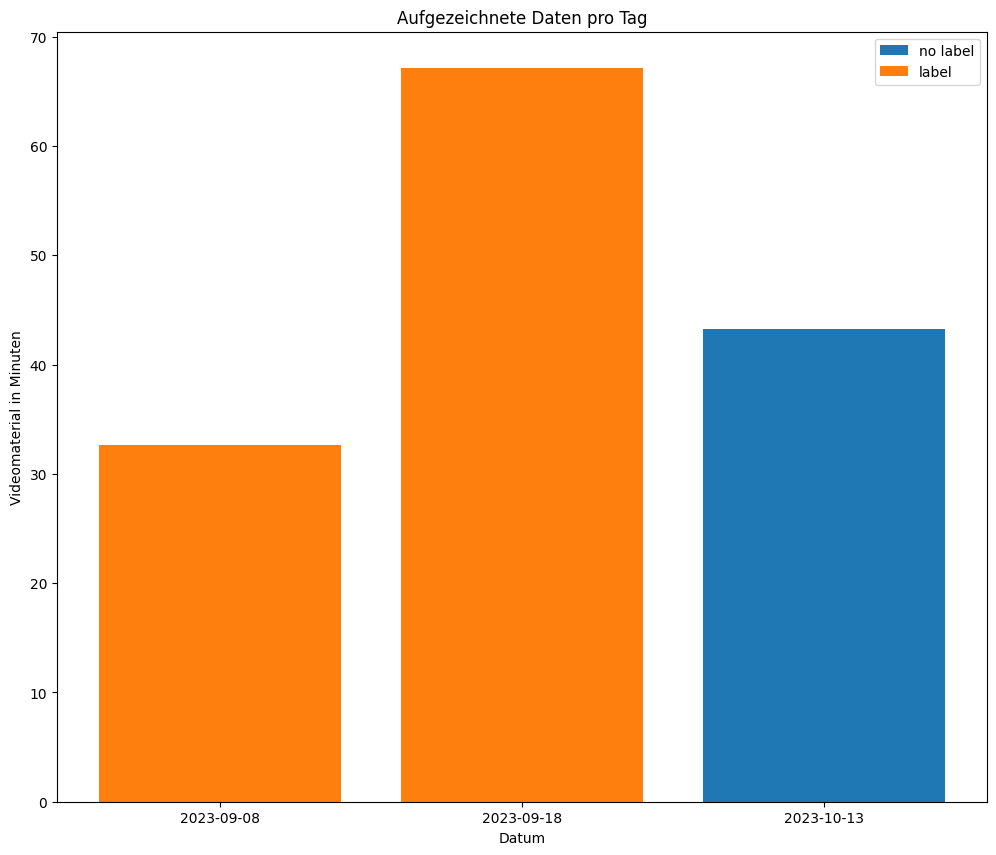

In [311]:
grouped_df = loop_df.groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()
grouped_df['labeled'] = \
loop_df[loop_df['human_labeled'] == True].groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()[
    'session_length']

grouped_df = grouped_df.fillna(0)
grouped_df
loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()
grouped_df['session_length'] / 60

label = ['label', 'no lable']
plt.figure(figsize=(12, 10))

plt.bar(grouped_df['timestamp'].astype(str), grouped_df['session_length'] /60, label='no label')
plt.bar(grouped_df['timestamp'].astype(str), grouped_df['labeled'] / 60, label='label')
plt.xlabel('Datum')
plt.ylabel('Videomaterial in Minuten')
plt.title('Aufgezeichnete Daten pro Tag')
#plt.ylim(0, 70)
plt.legend()

plt.savefig('diagrams/overview.png')

In [312]:
def get_user(id):
    user_df = table_to_df('users')
    users_loc = user_df.loc[user_df['id'] == id].values
    return f"{users_loc[0][1]} {users_loc[0][2]}"

2023-11-21 20:48:49,420 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-21 20:48:49,421 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2023-11-21 20:48:49,422 INFO sqlalchemy.engine.Engine [cached since 0.4081s ago] {'table_name': 'users', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2023-11-21 20:48:49,424 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_

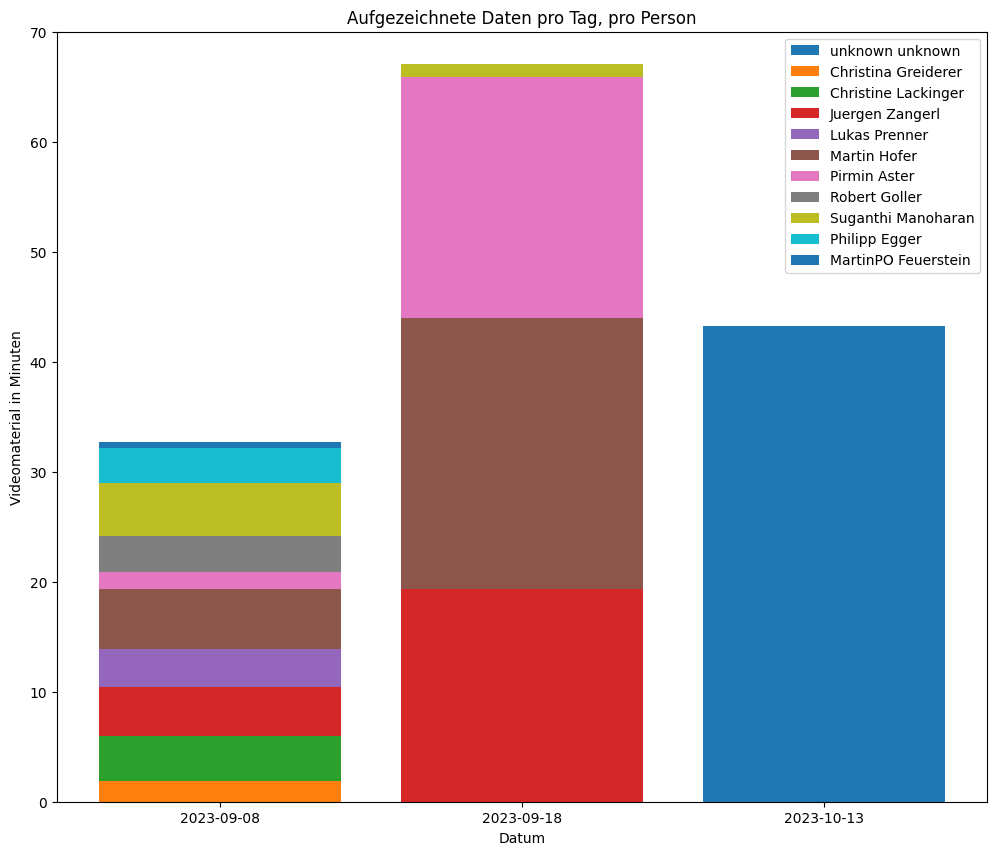

In [313]:
session_user_id_df_test = loop_df.groupby(loop_df['timestamp'].dt.date)['user_id'].unique()
session_user_id_df_test1 = loop_df.groupby([loop_df['timestamp'].dt.date, 'user_id']).size().unstack(fill_value=0)
session_user_time_df = loop_df.groupby([loop_df['timestamp'].dt.date, 'user_id'])['session_length'].sum().unstack(
    fill_value=0)
session_user_time_df = session_user_time_df.reset_index()
users_df = table_to_df('users')

#label = ['label', 'no lable']
plt.figure(figsize=(12, 10))
bottom = np.zeros(3)

for x in range(loop_df['user_id'].nunique()):
    plt.bar(session_user_time_df['timestamp'].astype(str), session_user_time_df[x + 1] / 60, label=f"{get_user(x + 1)}",
            bottom=bottom)
    bottom += session_user_time_df[x + 1] / 60
#plt.bar(grouped_df['timestamp'].astype(str), grouped_df['labeled']/60, label='label')
plt.xlabel('Datum')
plt.ylabel('Videomaterial in Minuten')
plt.ylim(0, 70)
plt.title('Aufgezeichnete Daten pro Tag, pro Person')
plt.legend()

plt.savefig('diagrams/person_per_day.png')

In [314]:
def overview():
    result = (
        f"Die DB enthält {loop_df['timestamp'].count()} Aufzeichnungen, das entspricht {loop_df['session_length'].sum()} Sekunden an Videomaterial:\n"
        f"\t\t{loop_df['human_labeled'].sum()} Aufzeichnungen sind von Menschen gelabelt ({(loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()/60):.2f} Minuten)\n"
        f"\t\t{(loop_df['human_labeled'] == False).sum()} Aufzeichnungen sind ungelabelt ({(loop_df.loc[loop_df['human_labeled'] == False, 'session_length'].sum()/60):.2f} Minuten)\n"
        f"Videolänge mean: {loop_df['session_length'].mean()} Sekunden\n"
        f"Videolänge median: {loop_df['session_length'].median()} Sekunden\n"
        f"Videolänge min: {loop_df['session_length'].min()} Sekunden\n"
        f"Videolänge max: {loop_df['session_length'].max()} Sekunden\n"
    )
    return result


In [315]:
def output_df_to_pdf(pdf, df):
    
    table_cell_widths = {}
    for col in df.columns:
        max_length = max(df[col].astype(str).apply(len).max(), len(col))
        table_cell_widths[col] = max_length * 2.5

    pdf.set_font('Courier', '', 10)
    
    for col in df.columns:
        pdf.cell(table_cell_widths[col], 6, col, align='C', border=1)
    pdf.ln(6)
    
    for _, row in df.iterrows():
        for col in df.columns:
            value = str(row[col])
            pdf.cell(table_cell_widths[col], 6, value, align='C', border=1)
        pdf.ln(6)


In [316]:
def get_time():
    return datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [317]:
#loop_df.to_json('your_file.json', orient='records')


In [328]:
from fpdf import FPDF

pdf = FPDF()
pdf.add_page()
pdf.set_font('Courier', 'B', 16)

pdf.image('diagrams/logo.png')
pdf.set_text_color(255,155,0)
pdf.cell(60, 10, txt='TensionTerminator Datareport')
pdf.ln(10)
pdf.set_font('Courier', '', 10)
pdf.set_text_color(0,0,0)
pdf.multi_cell(0,6, txt=overview())

pdf.image('diagrams/overview.png',5,100,200)
pdf.add_page()
pdf.image('diagrams/person_per_day.png',5,10,200)


#loop_df_noid = loop_df
### Transform the Date column as str dtype
#output_df_to_pdf(pdf, loop_df_noid.tail(3))

#output_df_to_pdf(pdf, loop_df_noid)
# 3. Output the PDF file
#pdf.output(f'pdf_reports/tt_data_report_{get_time()}.pdf', 'F')
pdf.output(f'pdf_reports/tt_data_report.pdf', 'F')

''